In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
from copy import deepcopy

from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal#, RealAmplitudes, PauliTwoDesign
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import YahooDataProvider
from qiskit.result import QuasiDistribution
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2#, Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit.quantum_info import SparsePauliOp, Pauli
from docplex.mp.advmodel import AdvModel

In [2]:
seed = 1093284
algorithm_globals.random_seed = seed
register_matplotlib_converters()
service = QiskitRuntimeService(channel="ibm_quantum",token="")

In [3]:
from typing import Dict
import mitiq.executor
from qiskit_ibm_runtime.ibm_backend import IBMBackend
from qiskit_ibm_runtime.options.estimator_options import EstimatorOptions
from qiskit_ibm_runtime.session import Session

class UDS_QEM_Estimator(EstimatorV2):
    def __init__(self, backend: str | IBMBackend | None = None, session: Session | None = None, options: Dict | EstimatorOptions | None = None):
        super().__init__(backend, session, options)

In [4]:
from collections.abc import Callable
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit_algorithms import AlgorithmError

class ModVQE(VQE):
    def _get_evaluate_energy(
            self,
            ansatz: QuantumCircuit,
            operator: BaseOperator,
        ) -> Callable[[np.ndarray], np.ndarray | float]:
            """Returns a function handle to evaluate the energy at given parameters for the ansatz.
            This is the objective function to be passed to the optimizer that is used for evaluation.

            Args:
                ansatz: The ansatz preparing the quantum state.
                operator: The operator whose energy to evaluate.

            Returns:
                A callable that computes and returns the energy of the hamiltonian of each parameter.

            Raises:
                AlgorithmError: If the primitive job to evaluate the energy fails.
            """
            num_parameters = ansatz.num_parameters

            # avoid creating an instance variable to remain stateless regarding results
            eval_count = 0

            def evaluate_energy(parameters: np.ndarray) -> np.ndarray | float:
                nonlocal eval_count

                # handle broadcasting: ensure parameters is of shape [array, array, ...]
                parameters = np.reshape(parameters, (-1, num_parameters)).tolist()
                # batch_size = len(parameters)

                try:
                    job = self.estimator.run([(ansatz, operator, parameters)])
                    estimator_result = job.result()
                except Exception as exc:
                    raise AlgorithmError("The primitive job to evaluate the energy failed!") from exc

                values = estimator_result.values

                if self.callback is not None:
                    metadata = estimator_result.metadata
                    for params, value, meta in zip(parameters, values, metadata):
                        eval_count += 1
                        self.callback(eval_count, params, value, meta)

                energy = values[0] if len(values) == 1 else values

                return energy

            return evaluate_energy

In [5]:
num_assets = 4
stocks = ["AAPL","IBM","NFLX","TSLA"]

In [6]:
def print_result(result, qubo):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = qubo.objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        pub = (ansatz, [hamiltonian], [current_vector])
        result = estimator.run(pubs=[pub]).result()
        current_cost = result[0].data.evs[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    return energy

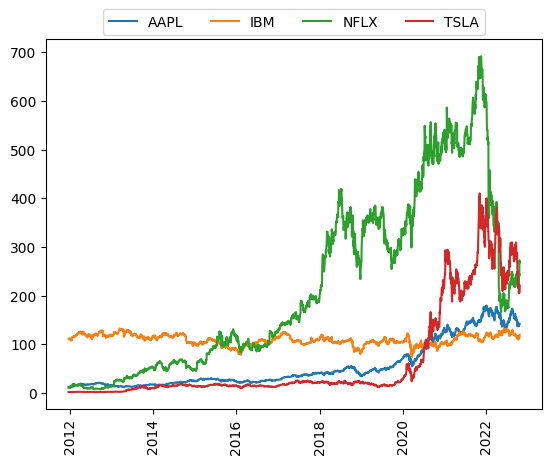

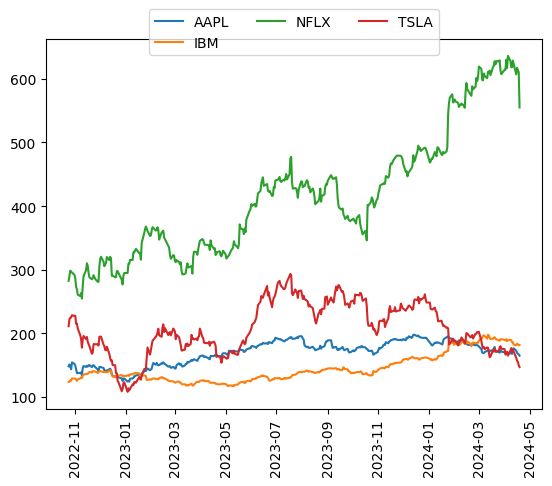

In [7]:
try:
    tr_data = YahooDataProvider(
            tickers=stocks,
            start=datetime.datetime(2011, 12, 23),
            end=datetime.datetime(2022, 10, 21),
        )
    tr_data.run()

    for (cnt, s) in enumerate(tr_data._tickers):
        plt.plot(tr_data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=4)
    plt.xticks(rotation=90)
    plt.show()
    # plt.savefig("Training data for VQE w/ QEM.png")
    
except QiskitFinanceError as ex:
    print(ex)
    print("Error retrieving data.")
    
try:
    te_data = YahooDataProvider(
        tickers=stocks,
        start=datetime.datetime(2022, 10, 22),
        end=datetime.datetime(2024, 4, 20),
    )
    te_data.run()

    for (cnt, s) in enumerate(te_data._tickers):
        plt.plot(te_data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
    # plt.savefig("Training data for VQE w/ QEM")
except QiskitFinanceError as ex:
    print(ex)
    print("Error retrieving data.")

In [8]:
tr_data._data[0]

Date
2011-12-23     12.194963
2011-12-27     12.291720
2011-12-28     12.174099
2011-12-29     12.249083
2011-12-30     12.245457
                 ...    
2022-10-14    137.207855
2022-10-17    141.203720
2022-10-18    142.532349
2022-10-19    142.641434
2022-10-20    142.175400
Name: Adj Close, Length: 2724, dtype: float64

In [9]:
out_data = pd.DataFrame()
for i,data in enumerate(tr_data._data):
    out_data[tr_data._tickers[i]] = data
out_data.to_csv('train_ticker_data.csv')
out_data = pd.DataFrame()
for i,data in enumerate(te_data._data):
    out_data[te_data._tickers[i]] = data
out_data.to_csv('test_ticker_data.csv')

Optimization Problem Setup

is basic rn, change to paper

and then after isinstance(quadratic optimization)
convert to Quadratic Unconstrained Binary Optimization (QUBO) problem,

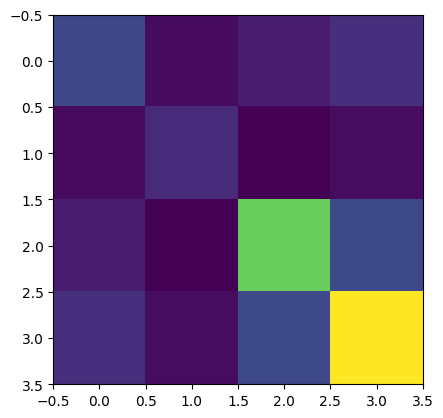

In [10]:
P = np.asarray(tr_data._data)[:,-1]
mu = tr_data.get_period_return_mean_vector()
sigma = tr_data.get_period_return_covariance_matrix()
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [11]:
print([1000, 1245,3103, 13450])
print(np.ceil(np.log2([1000, 1245,3103, 13450])))


[1000, 1245, 3103, 13450]
[10. 11. 12. 14.]


In [12]:
q = 0.5  # set risk factor
budget = 2000  # set budget
penalty = 10

qp = AdvModel('portfolio_optimization')
n_max = np.floor(budget/P) #  (8)
d = np.floor(np.log2(n_max)).astype(int) #ep (9)of binarizing elements di for each asset i depending on the price
dim_b = sum(d+1) #overall dimension of binarized target vector b

p_prime = P/budget # investment i as fraction of budget
mu_p = p_prime * mu #\mu'
sigma_p = (p_prime * sigma).T * p_prime #\Sigma'

C = []
for i,val in enumerate(d):
    row = np.zeros(dim_b)
    row[sum(d[:i]) + i:sum(d[:i+1]) + i + 1] = [2 ** j for j in range(val+1)]
    C.append(row)
C = np.array(C) #eq (11)

mu_p2 = C.T @ mu_p 
sigma_p2 = C.T @ sigma_p @ C 
p_prime2 = C.T @ p_prime

#bin var n - num shares per asset, to get the number of 
bin_vars = []
for i in range(len(P)):
    for j in range(d[i]+1):
        bin_vars.append(qp.binary_var(f"b_{i}_{j}"))

lin = np.dot(mu_p2,bin_vars)
quad = q * qp.quad_matrix_sum(sigma_p2,bin_vars,True)
qp.maximize(lin - quad)

constraint = np.dot(p_prime2,bin_vars)
qp.linear_constraint(constraint, ctsense='eq', rhs=1)
qp = from_docplex_mp(qp)
qubo = LinearEqualityToPenalty(penalty).convert(qp) #Eq. 14
ham, ham_constant = qubo.to_ising()#Eq. 16
print('Hamiltonian constant: ',ham_constant)

Hamiltonian constant:  -0.0020386304430503027


Classical Simulator

Quantum Simulator

In [13]:
print(service.backends())

[<IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]


In [14]:
real_backend = service.backend("ibm_osaka")
aer = AerSimulator.from_backend(real_backend)
pm = generate_preset_pass_manager(backend=aer, optimization_level=3)

In [15]:
print(aer)

AerSimulator('aer_simulator_from(ibm_osaka)'
             noise_model=<NoiseModel on ['x', 'sx', 'id', 'measure', 'reset', 'ecr']>)


In [28]:

ansatz = TwoLocal(ham.num_qubits, "ry", "cz", reps=3, entanglement="full")
params = 2 * np.pi * np.random.rand(ansatz.num_parameters) - np.pi
# ansatz.assign_parameters(params, True)
ansatz_isa = pm.run(ansatz)
ansatz_isa = ansatz_isa.decompose()
ansatz_isa.assign_parameters(params, True)
hamiltonian_isa = ham.apply_layout(layout=ansatz_isa.layout)
cobyla = COBYLA(maxiter=200)

In [ ]:

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
energies = []
noise_m = NoiseModel.from_backend(real_backend)
estimator = Estimator(backend_options={"noise_model":noise_m})
estimator.from_backend(real_backend)


NameError: name 'NoiseModel' is not defined

In [ ]:
callback = build_callback(ansatz_isa, hamiltonian_isa, estimator, callback_dict)
vqe_mes = ModVQE(estimator, ansatz, optimizer=cobyla,callback=cost_func)
for _ in range(2000):
    result = vqe_mes.compute_minimum_eigenvalue(operator=hamiltonian_isa)
    vqe_mes = ModVQE(estimator, ansatz, optimizer=cobyla,callback=cost_func,initial_point=result.optimal_point)
    energies.append(result.eigenvalue.real) 
    

average_energy = sum(energies) / len(energies)
print('Average minimum energy over 2000 runs:', average_energy)

In [ ]:
# fig, ax = plt.subplots()
# ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
# ax.set_xlabel("Iterations")
# ax.set_ylabel("Cost")
# plt.draw()

plt.hist(energies, bins=50)
plt.title('Energy Distribution over 2000 VQE Runs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

Real Quantum Device

In [40]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
qp = deepcopy(qubo)
result = exact_eigensolver.solve(qp)
print_result(result,qp)

Optimal: selection [1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1.], value 0.0032

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1]	0.0032		1.0000
